**PMD Demonstrator of a Data Pipeline**

This Notebook was developed within the frame of the joint project "Plattform MaterialDigital" ([PMD](https://materialdigital.de/)). It is supposed to show the benefits of the usage of semantically structured data that were created in a typical pipeline of data generation from materials testing to RDF data in a triple store (example for semantic interoperability).

It contains some scripts to demonstrate the digitalization of test (material characterization) processes and the subsequent analysis and evaluation of data in Materials Science and Engineering (MSE). Hence, the path of data being generated, processed, stored, and queried is depicted exemplary for tensile tests to metallic materials at room temperature combined with the analysis of precipitates particle sizes obtained from a typical transmission electron microscopy (TEM) process. As a form of the well-known Orowan relation is depicted with this analysis method, this Jupyter Notebook is referred to as the PMD Orowan Demonstrator which is also available on the corresponding [PMD GitHub repository](https://github.com/materialdigital/demo-orowan). The data used within this demonstrator is also available in an open [Zenodo repository](). Furthermore, the ontologies used are to be found using their namespaces: [PMDco](https://w3id.org/pmd/co), [TTO](https://w3id.org/pmd/tto), and [PGO](https://w3id.org/pmd/pgo). The patterns that have been used to generate the data are described in [The PMDCo 2.0 documentation](https://miro.com/app/board/uXjVPn5wGiA=/).

# Package Installation & Imports

In [1]:
# Used Python packages have to be installed, first.
%pip install --upgrade pip
%pip install rdflib
%pip install owlready2
%pip install sparqlwrapper
%pip install tabulate


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import of relevant package parts
import re
import os.path

import pandas as pd
import owlready2 as or2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from rdflib import Graph, Namespace, URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS, SKOS, XSD, OWL, DC, PROV

from urllib.parse import quote, urlparse

from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean


import tabulate

# Define Helper Functions

In [3]:
# Function to transform inputs to IRIs.
def to_iri(input):
    try:
        return input.iri
    except:
        pass
    return input

# Function to write the result of a SPARQL query into a (pandas) data frame.
def sparql_result_to_df(res):
    l = []
    for row in res:
        r = [ to_iri(item)  for item in row]
        l.append(r)
    return pd.DataFrame(l)

# Read in Data
We use the tensile data from:

von Hartrott, P., & Skrotzki, B. (2023). Room temperature and elevated temperature tensile test and elastic properties data of Al-alloy EN AW-2618A after different aging times and temperatures (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10377164

The data is in tabular form and needs some preprocessing before it can easily be worked with.


In [4]:
df = pd.read_excel("https://zenodo.org/records/10377164/files/dataset%20EN%20AW-2618A.xlsx", 
                   sheet_name="Tensiletest overview",
                   index_col="Experiment ID")
df.iloc[[0, 6, 13]] # Representative selection of values for "Material state"

,Material state,Test temperature [°C],Rp01 [MPa],Rp02 [MPa],Rm [MPa],Elongation after \nfracture A [%],Reduction \nof area Z [%],Strain rate \n[mm/mm/s],Testpiece \ngeometry,Remarks
Experiment ID,,,,,,,,,,
ABR5RTzl1,T61,20,341,365,428.0,0.053,0.0959,0.0001,DIN 50125 B6x30,NaN
ABR819zl2,T61 + 15 kh @ 190 °C,190,181,196,216.0,0.200,0.1968,0.0001,DIN 50125 B6x30,NaN
ABR7RTd1,T61 + 160 h @ 350 °C,20,122,131,NaN,NaN,NaN,0.0001,"d0=7 mm, Lc=10 mm",First 1/4 cycle of a strain controlled low cyc...


We have to preprocess the data from the column "Material state" to extract the intial material state, the aging duration and and aging temperature temperature. For this we use a regular expression and some transformations. As the last step of this series of operations we join the extracted aging duration and temperature to the dataframe `df`.

In [5]:
#
mapper = {0:"Initial state", 
          2:"Aging duration quantifier",
          3:"Aging duration factor",
          4:"Aging temperature [°C]"}
df_mat_state = df["Material state"].str.extract("(T61)( \+ ([\d]*) (k)?h @ ([\d]*) °C)?").rename(columns=mapper).drop(columns=[1])
display(df_mat_state)

#string_data_ELN_TT = open("TT_data.csv", encoding="utf-8").read()
#string_data_ELN_TEM = open("TEM_data.csv", encoding="utf-8").read()

,Initial state,Aging duration quantifier,Aging duration factor,Aging temperature [°C]
Experiment ID,,,,
ABR5RTzl1,T61,NaN,NaN,NaN
ABR58zl2,T61,NaN,NaN,NaN
ABR516zl3,T61,NaN,NaN,NaN
ABR518zl4,T61,NaN,NaN,NaN
ABR519zl8,T61,NaN,NaN,NaN
ABR8RTzl1,T61,15,k,190
ABR819zl2,T61,15,k,190
ABR9RTzl1,T61,25,k,190
ABR919zl2,T61,25,k,190


In [6]:
mask = ~(df_mat_state["Aging duration quantifier"].isna())

factor1 = df_mat_state["Aging duration quantifier"][mask].apply(int)
display(factor1)

Experiment ID
ABR8RTzl1       15
ABR819zl2       15
ABR9RTzl1       25
ABR919zl2       25
ABR10RTzl1      15
ABR1016zl2      15
ABR11RTzl1      25
ABR1116zl2      25
ABR7RTd1       160
ABR1RTd6         1
ABR2RTd3      8760
ABR3RTd2         1
ABR4RTd2      8760
Name: Aging duration quantifier, dtype: int64

In [7]:
factor2 = df_mat_state["Aging duration factor"][mask].replace({pd.NA:1, "k":1000})
display(factor2)

Experiment ID
ABR8RTzl1     1000
ABR819zl2     1000
ABR9RTzl1     1000
ABR919zl2     1000
ABR10RTzl1    1000
ABR1016zl2    1000
ABR11RTzl1    1000
ABR1116zl2    1000
ABR7RTd1         1
ABR1RTd6      1000
ABR2RTd3         1
ABR3RTd2      1000
ABR4RTd2         1
Name: Aging duration factor, dtype: int64

In [8]:
df_mat_state["Aging duration [h]"] = factor1*factor2
display(df_mat_state)

,Initial state,Aging duration quantifier,Aging duration factor,Aging temperature [°C],Aging duration [h]
Experiment ID,,,,,
ABR5RTzl1,T61,NaN,NaN,NaN,NaN
ABR58zl2,T61,NaN,NaN,NaN,NaN
ABR516zl3,T61,NaN,NaN,NaN,NaN
ABR518zl4,T61,NaN,NaN,NaN,NaN
ABR519zl8,T61,NaN,NaN,NaN,NaN
ABR8RTzl1,T61,15,k,190,15000.0
ABR819zl2,T61,15,k,190,15000.0
ABR9RTzl1,T61,25,k,190,25000.0
ABR919zl2,T61,25,k,190,25000.0


In [9]:
df = df.join(df_mat_state[["Aging temperature [°C]", "Aging duration [h]"]])
display(df)

,Material state,Test temperature [°C],Rp01 [MPa],Rp02 [MPa],Rm [MPa],Elongation after \nfracture A [%],Reduction \nof area Z [%],Strain rate \n[mm/mm/s],Testpiece \ngeometry,Remarks,Aging temperature [°C],Aging duration [h]
Experiment ID,,,,,,,,,,,,
ABR5RTzl1,T61,20,341,365,428.0,0.053,0.0959,0.0001,DIN 50125 B6x30,NaN,NaN,NaN
ABR58zl2,T61,80,321,340,407.0,0.070,0.0932,0.0001,DIN 50125 B6x30,NaN,NaN,NaN
ABR516zl3,T61,160,313,324,346.0,0.130,0.1554,0.0001,DIN 50125 B6x30,NaN,NaN,NaN
ABR518zl4,T61,180,288,300,320.0,0.110,0.1623,0.0001,DIN 50125 B6x30,NaN,NaN,NaN
ABR519zl8,T61,190,280,292,307.0,0.120,NaN,0.0001,DIN 50125 B6x30,Reduction of area was not evaluated on this te...,NaN,NaN
ABR8RTzl1,T61 + 15 kh @ 190 °C,20,226,246,342.0,0.079,0.1414,0.0001,DIN 50125 B6x30,NaN,190,15000.0
ABR819zl2,T61 + 15 kh @ 190 °C,190,181,196,216.0,0.200,0.1968,0.0001,DIN 50125 B6x30,NaN,190,15000.0
ABR9RTzl1,T61 + 25 kh @ 190 °C,20,222,236,330.0,0.083,0.1836,0.0001,DIN 50125 B6x30,NaN,190,25000.0
ABR919zl2,T61 + 25 kh @ 190 °C,190,168,183,210.0,0.195,0.1838,0.0001,DIN 50125 B6x30,NaN,190,25000.0


# Tensile test and TEM data graph creation
Add tensile test and TEM data to graphs and serialize graphs.
First add some general infos to our graph, like creators, etc which could be useful if they were published as datasets. (For publication a license for the data is indispensable!)

In [10]:
# Creating RDF graphs 'g' for the representation of the tensile test data ...
g = Graph()

# Definition of IRI prefixes and assignment of namespaces
pmdco = Namespace("https://w3id.org/pmd/co/")
g.bind("pmdco", pmdco)
unit = Namespace("http://qudt.org/vocab/unit/")
g.bind("unit", unit)
tto = Namespace("https://w3id.org/pmd/tto/")
g.bind("tto", tto)

# Namespace for instances (A-Box): tte - tensile test entities
tte = Namespace("https://w3id.org/pmd/resource/tte/")
g.bind("tte", tte)

# Turtle style abbreviation for RDF.type
a = RDF.type

# Creation of ontology, import of pmdco ontology. Additionally, creators are mentioned.
onto = URIRef(tte)
g.add((onto, a, OWL.Ontology))
g.add((onto, OWL.imports, URIRef(pmdco)))
g.add((onto, OWL.imports, URIRef(tto)))

# Add creators:
markus = URIRef("https://orcid.org/0000-0002-7094-5371")
bernd = URIRef("https://orcid.org/0000-0002-3717-7104")
joerg = URIRef("https://orcid.org/0000-0001-7192-7143")
philipp = URIRef("https://orcid.org/0000-0003-4971-3645")

g.add((onto, DC.creator, markus))
g.add((markus, RDFS.label, Literal("Markus Schilling", datatype=XSD.string)))
g.add((onto, DC.creator, bernd))
g.add((bernd, RDFS.label, Literal("Bernd Bayerlein", datatype=XSD.string)))
g.add((onto, DC.creator, joerg))
g.add((joerg, RDFS.label, Literal("Jörg Waitelonis", datatype=XSD.string)))
g.add((onto, DC.creator, philipp))
g.add((philipp, RDFS.label, Literal("Philipp von Hartrott", datatype=XSD.string)))

g.add((onto, DC.title, Literal("Tensile Test data Orowan example", datatype=XSD.string)))

<Graph identifier=N81a9b408cdd64f699c447b57cba1d84b (<class 'rdflib.graph.Graph'>)>

Next we transform the data from the dataframe `df` into triples according to the involved ontologies and PMD design patterns.

In [11]:
# Iterate over the full data table
# The pattern applied is from frame 27a in https://miro.com/app/board/uXjVPn5wGiA=/ 
for experiment_id, row in df.iterrows():
    testpiece_id      = "tp_" + experiment_id
    #machine           = row["machine"]
    temperature       = row["Test temperature [°C]"]
    rp01              = row["Rp01 [MPa]"]
    rp02              = row["Rp02 [MPa]"]
    rm                = row["Rm [MPa]"]
    strainrate        = row["Strain rate \n[mm/mm/s]"]
    agingtime         = row["Aging duration [h]"]
    agingtemp         = row["Aging temperature [°C]"]
    matstatename      = row["Material state"]
  
    # Creation of triples for all instances (considering all connections between them). 
    experimentIRI = URIRef(tte + experiment_id)
    g.add((experimentIRI, a, pmdco.ProcessIdentifier))
    g.add((experimentIRI, pmdco.value, Literal(experiment_id, datatype=XSD.string)))
  
    processIRI = URIRef(experimentIRI + "_process")
    g.add((processIRI, a, tto.TensileTest))
    g.add((processIRI, pmdco.characteristic, experimentIRI))
  
    # Test piece as input prior to tensile test
    testpieceID_IRI = URIRef(tte + f"testpiece_name/{testpiece_id}")
    g.add((testpieceID_IRI, a, pmdco.TestPieceName))
    g.add((testpieceID_IRI, a, pmdco.Metadata))
    g.add((testpieceID_IRI, pmdco.value, Literal(testpiece_id, datatype=XSD.string)))
  
    testpieceIRI = URIRef(testpieceID_IRI  + f"_testpiece/{testpiece_id}")
    g.add((testpieceIRI, a, pmdco.TestPiece))
    g.add((testpieceIRI, pmdco.characteristic, testpieceID_IRI))
  
    # Test piece(s) as output after tensile test (typically, 2 fractured parts will be formed)
    testpiecePart1AfterTest_ID = URIRef(testpieceID_IRI + "_afterTest_1")
    g.add((testpiecePart1AfterTest_ID, a, pmdco.TestPieceName))
    g.add((testpiecePart1AfterTest_ID, a, pmdco.Metadata))
    g.add((testpiecePart1AfterTest_ID, pmdco.value, Literal(testpiece_id + "_afterTest_1", datatype=XSD.string)))
    testpiecePart1AfterTest = URIRef(testpieceIRI  + "_testpiece_afterTest_1")
    g.add((testpiecePart1AfterTest, a, pmdco.TestPiece))
    g.add((testpiecePart1AfterTest, pmdco.characteristic, testpiecePart1AfterTest_ID))
  
    testpiecePart2AfterTest_ID = URIRef(testpieceID_IRI + "_afterTest_2")
    g.add((testpiecePart2AfterTest_ID, a, pmdco.TestPieceName))
    g.add((testpiecePart2AfterTest_ID, a, pmdco.Metadata))
    g.add((testpiecePart2AfterTest_ID, pmdco.value, Literal(testpiece_id + "_afterTest_2", datatype=XSD.string)))
    testpiecePart2AfterTest = URIRef(testpieceIRI  + "_testpiece_afterTest_2")
    g.add((testpiecePart2AfterTest, a, pmdco.TestPiece))
    g.add((testpiecePart2AfterTest, pmdco.characteristic, testpiecePart2AfterTest_ID))

    
    g.add((testpieceIRI, pmdco.composedOf, testpiecePart1AfterTest))
    g.add((testpieceIRI, pmdco.composedOf, testpiecePart2AfterTest))
    
    g.add((processIRI, pmdco.input, testpieceIRI))
    g.add((processIRI, pmdco.output, testpiecePart1AfterTest))
    g.add((processIRI, pmdco.output, testpiecePart2AfterTest))
  
    # The next section contains secondary data.
    rp01IRI = URIRef(experimentIRI + "_rp01")
    g.add((rp01IRI, a, tto.Rp01))
    g.add((rp01IRI, a, pmdco.SecondaryData))
    g.add((rp01IRI, a, pmdco.Measurement))
    g.add((rp01IRI, pmdco.value, Literal(rp01, datatype=XSD.float)))
    g.add((rp01IRI, pmdco.unit, unit.MegaPa))
    g.add((processIRI, pmdco.output, rp01IRI))
    g.add((testpieceIRI, pmdco.characteristic, rp01IRI))
  
    rp02IRI = URIRef(experimentIRI + "_rp02")
    g.add((rp02IRI,      a,                    tto.Rp02))
    g.add((rp02IRI,      a,                    pmdco.SecondaryData))
    g.add((rp02IRI,      a,                    pmdco.Measurement))
    g.add((rp02IRI,      pmdco.value,          Literal(rp02, datatype=XSD.float)))
    g.add((rp02IRI,      pmdco.unit,           unit.MegaPa))
    g.add((processIRI,   pmdco.output,         rp02IRI))
    g.add((testpieceIRI, pmdco.characteristic, rp02IRI))
  
    # Not all experiments contain Rm
    if not pd.isna(rm):
        rmIRI = URIRef(experimentIRI + "_tensileStrength")
        g.add((rmIRI, a, tto.TensileStrength))
        g.add((rmIRI, a, pmdco.SecondaryData))
        g.add((rmIRI, a, pmdco.Measurement))
        g.add((rmIRI, pmdco.value, Literal(rm, datatype=XSD.float)))
        g.add((rmIRI, pmdco.unit, unit.MegaPa))
        g.add((processIRI, pmdco.output, rmIRI))
        g.add((testpieceIRI, pmdco.characteristic, rmIRI))
  
    # The next section contains metadata.
    #machineIRI = URIRef(experimentIRI + "_machine")
    machineIRI = BNode()
    g.add((machineIRI, a, tto.TensileTestingMachine))
    g.add((machineIRI, a, pmdco.Metadata))
    #g.add((machineIRI, pmdco.value, Literal(machine, datatype=XSD.string)))
    g.add((processIRI, pmdco.executedBy, machineIRI))
  
    temperatureIRI = URIRef(experimentIRI + "_temperature")
    g.add((temperatureIRI, a, pmdco.EnvironmentalTemperature))
    g.add((temperatureIRI, a, pmdco.Metadata))
    g.add((temperatureIRI, a, pmdco.Measurement))
    g.add((temperatureIRI, pmdco.value, Literal(temperature, datatype=XSD.float)))
    g.add((temperatureIRI, pmdco.unit, unit.DEG_C))
    g.add((processIRI, pmdco.characteristic, temperatureIRI))
  
    setTemperatureIRI = URIRef(experimentIRI + "_setTemperature")
    g.add((temperatureIRI, a, pmdco.EnvironmentalTemperature))
    g.add((temperatureIRI, a, pmdco.Metadata))
    g.add((temperatureIRI, a, pmdco.SetPoint))
    g.add((temperatureIRI, pmdco.value, Literal(temperature, datatype=XSD.float)))
    g.add((temperatureIRI, pmdco.unit, unit.DEG_C))
    g.add((processIRI, pmdco.characteristic, setTemperatureIRI))
  
    #operatorIRI = URIRef(experimentIRI + "_operator")
    operatorIRI = BNode()
    g.add((operatorIRI, a, pmdco.Operator))
    g.add((operatorIRI, a, pmdco.Metadata))
    #g.add((operatorIRI, pmdco.value, Literal(operator, datatype=XSD.string)))
    g.add((processIRI, pmdco.characteristic, operatorIRI))
  
    strainrateIRI = URIRef(experimentIRI + "_strainRate")
    g.add((strainrateIRI, a, tto.StrainRate))
    g.add((strainrateIRI, a, pmdco.Metadata))
    g.add((strainrateIRI, a, pmdco.SetPoint))
    g.add((strainrateIRI, pmdco.value, Literal(strainrate, datatype=XSD.float)))
    g.add((processIRI, pmdco.input, strainrateIRI))

    # Not all testpieces have been aged. 
    if not pd.isna(agingtime):
        agingtimeIRI = URIRef(experimentIRI + "_agingTime")
        g.add((agingtimeIRI, a, pmdco.AgingTime))
        g.add((agingtimeIRI, a, pmdco.Metadata))
        g.add((agingtimeIRI, a, pmdco.SetPoint))
        g.add((agingtimeIRI, pmdco.value, Literal(agingtime, datatype=XSD.float)))
        g.add((agingtimeIRI, pmdco.unit, unit.HR))
        g.add((processIRI, pmdco.characteristic, agingtimeIRI))

    if not pd.isna(agingtemp):
        agingtemperatureIRI = URIRef(experimentIRI + "_agingTemperature")
        g.add((agingtemperatureIRI, a, pmdco.AgingTemperature))
        g.add((agingtemperatureIRI, a, pmdco.Metadata))
        g.add((agingtemperatureIRI, a, pmdco.SetPoint))
        g.add((agingtemperatureIRI, pmdco.value, Literal(agingtemp, datatype=XSD.float)))
        g.add((agingtemperatureIRI, pmdco.unit, unit.DEG_C))
        g.add((processIRI, pmdco.characteristic, agingtemperatureIRI))
  
    matstatenameIRI = URIRef(experimentIRI + "_materialStateName")
    g.add((matstatenameIRI, a, pmdco.MaterialDesignation))
    g.add((matstatenameIRI, a, pmdco.Metadata))
    g.add((matstatenameIRI, pmdco.value, Literal(matstatename, datatype=XSD.string)))
    g.add((processIRI, pmdco.characteristic, matstatenameIRI))

  # break

## TEM graph creation

We use the TEM data from: 

Rockenhäuser, C., & Skrotzki, B. (2023). Radii of S-phase Al2CuMg in Al-alloy EN AW-2618A after different aging times at 190°C (1.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7625259



In [12]:
sheets = pd.read_excel("https://zenodo.org/records/7625259/files/radii_190C_aging_V1.1.xlsx", sheet_name=None)
list(sheets)

['T61',
 '190 °C, 250 h',
 '190 °C, 1000 h',
 '190 °C, 2500 h',
 '190 °C, 5000 h',
 '190 °C, 8760 h',
 '190 °C, 25000 h',
 '190 °C, 88 h, 181 MPa',
 '190 °C, 400 h, 181 MPa',
 '190 °C, 1002 h, 128 MPa',
 '190 °C, 1820 h, 128 MPa',
 '190 °C, 4172 h, 79 MPa']

In [13]:
display(sheets["T61"])

,Sample,Image,Particle number,Area,Weighed X-Position Central Point,Weighed Y-Position Central Point,Perimeter,Elipse fit Major axis,Elipse fit Minor axis,Elipse angle,Feret caliper,FeretX,FeretY,Feret angle,Min Feret,Radius [nm]
0,1,1,1,299,409.410,16.420,63.113,20.301,18.753,51.196,21.954,404,26,59.931,19.000,1.463362
1,1,1,2,730,1007.125,21.760,101.154,33.430,27.803,171.384,34.366,990,19,171.634,28.000,2.286534
2,1,1,3,595,1331.226,38.766,90.326,29.282,25.872,97.280,30.265,1328,24,97.595,26.000,2.064309
3,1,1,4,918,594.272,44.496,114.225,34.992,33.403,174.608,37.162,579,52,23.806,33.877,2.564116
4,1,1,5,1129,1943.564,47.698,126.468,42.578,33.761,158.031,43.267,1923,38,146.310,35.055,2.843566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2,3,165,331,1355.618,2003.775,67.012,21.925,19.222,55.249,23.022,1350,2014,55.620,19.799,1.539679
1729,2,3,166,199,793.515,2002.299,51.698,17.679,14.332,22.678,18.601,786,2008,36.254,15.000,1.193831
1730,2,3,167,804,1238.236,2024.877,133.681,53.856,19.008,56.489,54.406,1225,2045,53.973,24.572,2.399630
1731,2,3,168,607,1704.803,2016.171,91.841,32.301,23.927,61.923,34.000,1697,2031,61.928,24.984,2.085022


In [14]:
# Create a graph 'h' for the transmission electron microscopy data, respectively
h = Graph()

# Definition of IRI prefixes (namespaces)
pmdco = Namespace("https://w3id.org/pmd/co/")
h.bind("pmdco", pmdco)
qudt = Namespace("http://qudt.org/vocab/unit/")
h.bind("qudt", qudt)
pgo = Namespace("https://w3id.org/pmd/pgo/")
h.bind("pgo", pgo)

# Turtle style abbreviation for RDF.type
a = RDF.type

# Namespace for instances (A-Box)
pmdao_pge = Namespace("https://w3id.org/pmd/resource/pge/")
h.bind("pmdao_pge", pmdao_pge)

# Make the data be real ontologies that we can check and import of base ontology. Additionally, creators are mentioned.
onto = URIRef(pmdao_pge)
h.add((onto, a, OWL.Ontology))
h.add((onto, OWL.imports, URIRef(pmdco)))
h.add((onto, OWL.imports, URIRef("https://w3id.org/pmd/pgo/"))) 

# Add creators:
markus = URIRef("https://orcid.org/0000-0002-7094-5371")
bernd = URIRef("https://orcid.org/0000-0002-3717-7104")
joerg = URIRef("https://orcid.org/0000-0001-7192-7143")
philipp = URIRef("https://orcid.org/0000-0003-4971-3645")

h.add((onto, DC.creator, markus))
h.add((markus, RDFS.label, Literal("Markus Schilling", datatype=XSD.string)))
h.add((onto, DC.creator, bernd))
h.add((bernd, RDFS.label, Literal("Bernd Bayerlein", datatype=XSD.string)))
h.add((onto, DC.creator, joerg))
h.add((joerg, RDFS.label, Literal("Jörg Waitelonis", datatype=XSD.string)))
h.add((onto, DC.creator, philipp))
h.add((philipp, RDFS.label, Literal("Philipp von Hartrott", datatype=XSD.string)))

h.add((onto, DC.title, Literal("Precipitate geometry data Orowan example", datatype=XSD.string)))


<Graph identifier=N4c912fcf1f5942379c917fdb9ef9c5cf (<class 'rdflib.graph.Graph'>)>

In [15]:
# Put some information that about our measurment equipment: the manufacturer 
# of the device, device identifier, etc.
transmissionElectronMicroscopeIRI = URIRef("https://bam.de/equipment/STEM_JEOL_JEM_2200_FS_No_4")
h.add((transmissionElectronMicroscopeIRI, a, pmdco.TransmissionElectronMicroscope))

tEMManufacturerIRI = URIRef("https://www.jeol.de")
h.add((tEMManufacturerIRI, a, pmdco.Manufacturer))
h.add((tEMManufacturerIRI, a, pmdco.Metadata))
h.add((transmissionElectronMicroscopeIRI, pmdco.characteristic, tEMManufacturerIRI))
h.add((tEMManufacturerIRI, RDFS.label, Literal("JEOL")))

manufacturerSeriesIRI = URIRef("https://www.jeol.de/products/STEM_JEM_2200_FS")
h.add((manufacturerSeriesIRI, a, pmdco.NodeSeries))
h.add((manufacturerSeriesIRI, a, pmdco.Metadata))
h.add((transmissionElectronMicroscopeIRI, pmdco.characteristic, manufacturerSeriesIRI))
h.add((manufacturerSeriesIRI, RDFS.label, Literal("STEM_JEOL_JEM_2200_FS")))


# Some preparation for the processing of the sheets loaded above:

# Pattern for extraction of test conditions from the sheet names
prog = re.compile(pattern = "(\d+) °C, (\d+) h(, (\d+) MPa)?")

# Conversion factor from pixel to nanometer (data is given in px)
# The 0.025 given in content.pdf is wrong (for areas 0.025 = 0.15^2)
px_per_nm = 1./0.15 

# Now go sheet by sheet
for sheet_name, sheet in sheets.items():
    # Create nice labels (specimenMaterialStateName) and extract some conditions (aging time, aging temperature)
    # from the sheet names.
    m = prog.match(sheet_name)
    if m:
        specimenAgingtime              = int(m.groups()[1])
        specimenAgingT                 = int(m.groups()[0])
        if m[3]:
            specimenCreepStress        = int(m.groups()[3])
            scs = f", {specimenCreepStress} MPa"
        else:
            specimenCreepStress        = pd.NA
            scs = ""
        if specimenAgingtime%1000 == 0:
            satim = f"{int(specimenAgingtime/1000)} kh"
        else:
            satim = f"{specimenAgingtime} h"
        specimenMaterialStateName      = f"T61 + {satim} @ {specimenAgingT} °C" + scs 
    else:
        specimenAgingtime              = pd.NA
        specimenAgingT                 = pd.NA
        specimenCreepStress            = pd.NA
        specimenMaterialStateName      = sheet_name
 
    # Iterate over the single lines contained in the sheet while grouping them 
    # to their respective Sample (column A) and Image (column B).
    for (specimen_no, image_no), particles in sheets[sheet_name].groupby(by=["Sample", "Image"]):
        # Create IDs for reuse in IRIs later on.
        specimen_ID = quote(specimenMaterialStateName + "_" + str(specimen_no))
        image_ID    = specimen_ID + "_" + str(image_no)

        
        # Make some statements about the specimens and associated entities...
        # ... create a pmdco:SpecimenName
        specimen_name_IRI = URIRef(pmdao_pge +  f"specimen_name/{specimen_ID}")
        h.add((specimen_name_IRI, a, pmdco.SpecimenName))
        h.add((specimen_name_IRI, a, pmdco.Metadata))
        h.add((specimen_name_IRI, pmdco.value, Literal(specimenMaterialStateName + ", s:" + str(specimen_no))))
        # ... create a pmdco:Specimen and associate it with the pmdco:SpecimenName
        specimenIRI = URIRef(pmdao_pge +  f"specimen/{specimen_ID}")
        h.add((specimenIRI, a, pmdco.Specimen))
        h.add((specimenIRI, pmdco.characteristic, specimen_name_IRI))
        # ... create a pmdco:TransmissionElectronMicroscopy process that 
        # had the pmdco:Specimen as input
        tEMProcessIRI = URIRef(pmdao_pge +  f"tem_process/{specimen_ID}")
        h.add((tEMProcessIRI, a, pmdco.TransmissionElectronMicroscopy))
        h.add((tEMProcessIRI, pmdco.input, specimenIRI))
        h.add((transmissionElectronMicroscopeIRI, pmdco.executes, tEMProcessIRI))
        # ... create a pmdco:AgingTime metadata and associate it with the pmdco:Specimen
        specimenAgingtimeIRI = URIRef(pmdao_pge +  f"aging_time_{quote(str(specimenAgingtime))}")
        h.add((specimenAgingtimeIRI, a, pmdco.AgingTime))
        h.add((specimenAgingtimeIRI, a, pmdco.Metadata))
        h.add((specimenAgingtimeIRI, pmdco.value, Literal(specimenAgingtime)))
        h.add((specimenAgingtimeIRI, pmdco.unit, qudt.HR))
        h.add((specimenIRI, pmdco.characteristic, specimenAgingtimeIRI))
        # ... create a pmdco:AgingTemperature metadata and associate it with the pmdco:Specimen
        specimenAgingTIRI = URIRef(pmdao_pge +  f"aging_tempr_{quote(str(specimenAgingT))}")
        h.add((specimenAgingTIRI, a, pmdco.AgingTemperature))
        h.add((specimenAgingTIRI, a, pmdco.Metadata))
        h.add((specimenAgingTIRI, pmdco.value, Literal(specimenAgingT)))
        h.add((specimenAgingTIRI, pmdco.unit, qudt.DEG_C))
        h.add((specimenIRI, pmdco.characteristic, specimenAgingTIRI))
        # ... create a pmdco:CreepStress metadata and associate it with the pmdco:Specimen
        specimenCreepStressIRI = URIRef(pmdao_pge +  f"aging_stress_{quote(str(specimenCreepStress))}")
        h.add((specimenCreepStressIRI, a, pmdco.CreepStress))
        h.add((specimenCreepStressIRI, a, pmdco.Metadata))
        h.add((specimenCreepStressIRI, pmdco.value, Literal(specimenCreepStress)))
        h.add((specimenCreepStressIRI, pmdco.unit, qudt.MegaPA))
        h.add((specimenIRI, pmdco.characteristic, specimenCreepStressIRI))
        # ... create a pmdco:MaterialDesignation metadata and associate it with the pmdco:Specimen
        specimenMaterialStateNameIRI = URIRef(pmdao_pge +  f"material_state/{quote(specimenMaterialStateName)}")
        h.add((specimenMaterialStateNameIRI, a, pmdco.MaterialDesignation))
        h.add((specimenMaterialStateNameIRI, a, pmdco.Metadata))
        h.add((specimenMaterialStateNameIRI, pmdco.value, Literal(specimenMaterialStateName)))
        h.add((specimenIRI, pmdco.characteristic, specimenMaterialStateNameIRI))
        h.add((specimenIRI, pmdco.characteristic, URIRef("https://w3id.org/dmi/www.din.de/DIN_EN_573-3_2022-09/EN_AW-2618A")))
        # ... create a pmdco:Identifier for the image
        image_IDIRI = URIRef(pmdao_pge +  f"image_name/{image_ID}")
        h.add((image_IDIRI, a, pmdco.Identifier))
        h.add((image_IDIRI, a, pmdco.Metadata))
        h.add((image_IDIRI, pmdco.value, Literal(image_ID)))
        # ... create a pgo:DarkFieldImage and associate it with the pmdco:Identifier
        dFImage_IRI = URIRef(pmdao_pge +  f"image/{image_ID}")
        h.add((dFImage_IRI, a, pgo.DarkFieldImage))
        h.add((dFImage_IRI, pmdco.characteristic, image_IDIRI))
        h.add((tEMProcessIRI, pmdco.output, dFImage_IRI))
        # ... create a pgo:CalibrationFactor metadata for the calibration factor and associate it with the pgo:DarkFieldImage
        calibrationFactorIRI = URIRef(pmdao_pge +  f"image_calibration_factor/{image_ID}")
        h.add((calibrationFactorIRI, a, pmdco.Metadata))
        h.add((calibrationFactorIRI, a, pgo.CalibrationFactor))
        h.add((calibrationFactorIRI, pmdco.value, Literal(px_per_nm)))
        h.add((calibrationFactorIRI, pmdco.unit, pmdco.PixelPerNanometer))
        h.add((dFImage_IRI, pmdco.characteristic, calibrationFactorIRI))
        
        
        # Now iterate over individual particles of the image that we will put in the graph 'h'
        for particle_no, particle_data in particles.set_index("Particle number").iterrows():
            particle_ID                    = image_ID + "_" + str(particle_no)
            
            # ... create a pgo:ImageAnalysisProcess that is concerned with this soul particle
            precipitateGeometryMeasurementIRI = URIRef(pmdao_pge +  f"geometry_measurement_{particle_ID}")
            h.add((precipitateGeometryMeasurementIRI, a, pgo.ImageAnalysisProcess))
            h.add((precipitateGeometryMeasurementIRI, pmdco.input, dFImage_IRI))
            h.add((tEMProcessIRI, pmdco.nextProcess, precipitateGeometryMeasurementIRI))
            # ... create a pgo:PrecipitateNumber and associate it with the above pgo:ImageAnalysisProcess
            precipitateNumberIRI = URIRef(pmdao_pge +  f"particle_number_{particle_ID}")
            h.add((precipitateNumberIRI, a, pgo.PrecipitateNumber))
            h.add((precipitateNumberIRI, a, pmdco.PrimaryData))
            h.add((precipitateNumberIRI, a, pmdco.Measurement))
            h.add((precipitateNumberIRI, pmdco.value, Literal(particle_ID)))
            h.add((precipitateGeometryMeasurementIRI, pmdco.characteristic, precipitateNumberIRI))
            # ... create a pgo:ParticleArea primary datum and associate it with the above pgo:ImageAnalysisProcess
            particleAreaIRI = URIRef(pmdao_pge +  f"particle_area_{particle_ID}")
            h.add((particleAreaIRI, a, pgo.ParticleArea))
            h.add((particleAreaIRI, a, pmdco.PrimaryData))
            h.add((particleAreaIRI, a, pmdco.Measurement))
            h.add((particleAreaIRI, pmdco.value, Literal(particle_data["Area"])))
            h.add((particleAreaIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, particleAreaIRI))
            # ... create a pgo:WeightedXCoordinate datum and associate it with the above pgo:ImageAnalysisProcess
            weightedXPositionCentralPointIRI = URIRef(pmdao_pge +  f"weighted_x_position_{particle_ID}")
            h.add((weightedXPositionCentralPointIRI, a, pgo.WeightedXCoordinate))
            h.add((weightedXPositionCentralPointIRI, a, pmdco.PrimaryData))
            h.add((weightedXPositionCentralPointIRI, a, pmdco.Measurement))
            h.add((weightedXPositionCentralPointIRI, pmdco.value, Literal(particle_data["Weighed X-Position Central Point"])))
            h.add((weightedXPositionCentralPointIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, weightedXPositionCentralPointIRI))
            # ... create a pgo:WeightedYCoordinate datum and associate it with the above pgo:ImageAnalysisProcess
            weightedYPositionCentralPointIRI = URIRef(pmdao_pge +  f"weighted_y_position_{particle_ID}")
            h.add((weightedYPositionCentralPointIRI, a, pgo.WeightedYCoordinate))
            h.add((weightedYPositionCentralPointIRI, a, pmdco.PrimaryData))
            h.add((weightedYPositionCentralPointIRI, a, pmdco.Measurement))
            h.add((weightedYPositionCentralPointIRI, pmdco.value, Literal(particle_data["Weighed Y-Position Central Point"])))
            h.add((weightedYPositionCentralPointIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, weightedYPositionCentralPointIRI))
            # ... create a pgo:Perimeter datum and associate it with the above pgo:ImageAnalysisProcess
            perimeterIRI = URIRef(pmdao_pge +  f"perimeter_{particle_ID}")
            h.add((perimeterIRI, a, pgo.Perimeter))
            h.add((perimeterIRI, a, pmdco.PrimaryData))
            h.add((perimeterIRI, a, pmdco.Measurement))
            h.add((perimeterIRI, pmdco.value, Literal(particle_data["Perimeter"])))
            h.add((perimeterIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, perimeterIRI))
            # ... create a ... datum and associate it with the above pgo:ImageAnalysisProcess
            elipseFitMajorAxisIRI = URIRef(pmdao_pge +  f"elipse_fit_major_axis_{particle_ID}")
            h.add((elipseFitMajorAxisIRI, a, pgo.MajorAxisDiameter))
            h.add((elipseFitMajorAxisIRI, a, pmdco.PrimaryData))
            h.add((elipseFitMajorAxisIRI, a, pmdco.Measurement))
            h.add((elipseFitMajorAxisIRI, pmdco.value, Literal(particle_data["Elipse fit Major axis"])))
            h.add((elipseFitMajorAxisIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, elipseFitMajorAxisIRI))
            # ... create a ... datum and associate it with the above pgo:ImageAnalysisProcess
            elipseFitMinorAxisIRI = URIRef(pmdao_pge +  f"elipse_fit_minor_axis_{particle_ID}")
            h.add((elipseFitMinorAxisIRI, a, pgo.MinorAxisDiameter))
            h.add((elipseFitMinorAxisIRI, a, pmdco.PrimaryData))
            h.add((elipseFitMinorAxisIRI, a, pmdco.Measurement))
            h.add((elipseFitMinorAxisIRI, pmdco.value, Literal(particle_data["Elipse fit Minor axis"])))
            h.add((elipseFitMinorAxisIRI, pmdco.unit, pmdco.Pixel))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, elipseFitMinorAxisIRI))
            # ... create a ... datum and associate it with the above pgo:ImageAnalysisProcess
            particleRadius_nmIRI = URIRef(pmdao_pge +  f"particle_radius_nm{particle_ID}")
            h.add((particleRadius_nmIRI, a, pgo.ParticleRadius))
            h.add((particleRadius_nmIRI, a, pmdco.SecondaryData))
            h.add((particleRadius_nmIRI, a, pmdco.Measurement))
            h.add((particleRadius_nmIRI, pmdco.value, Literal(particle_data["Radius [nm]"])))
            h.add((particleRadius_nmIRI, pmdco.unit, qudt.NanoM))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, particleRadius_nmIRI))
            # ... create a PROV:SoftwareAgent metadata and associate it with the above pgo:ImageAnalysisProcess
            softwareAgentIRI = URIRef("https://imagej.net/software/imagej/")
            h.add((softwareAgentIRI, a, PROV.SoftwareAgent))
            h.add((softwareAgentIRI, a, pmdco.Metadata))
            h.add((softwareAgentIRI, RDFS.label, Literal("ImageJ")))
            h.add((precipitateGeometryMeasurementIRI, PROV.wasAssociatedWith, softwareAgentIRI))

            _="""
            labimage_IDIRI = URIRef(pmdao_pge +  f"image_name/{image_ID}")
            h.add((labimage_IDIRI, a, pmdco.Identifier))
            h.add((labimage_IDIRI, a, pmdco.Metadata))
            h.add((labimage_IDIRI, pmdco.value, Literal(labimage_ID)))

            labDFImageIRI = URIRef(pmdao_pge +  f"image/{image_ID}")
            h.add((labDFImageIRI, a, pmdco.Image))
            h.add((labDFImageIRI, pmdco.characteristic, labimage_IDIRI))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, labDFImageIRI))
            """
            regionOfInterestIRI = URIRef(pmdao_pge +  f"region_of_interest/{particle_ID}")
            h.add((regionOfInterestIRI, a, pmdco.RegionOfInterest))
            h.add((regionOfInterestIRI, a, pgo.Particle))
            h.add((precipitateGeometryMeasurementIRI, pmdco.output, regionOfInterestIRI))        



## Graph Serialization

In this section, graph h containing TEM data of precipitate analysis is serialized to be included in a local triple store used for SPARQL querying.

In [16]:
# Serialize graphs 'g' (tensile data) and 'h' (TEM data) 
g.serialize("tensile_data.rdf", format='application/rdf+xml', encoding="utf-8")
h.serialize("TEM_data.rdf", format='application/rdf+xml', encoding="utf-8")


<Graph identifier=N4c912fcf1f5942379c917fdb9ef9c5cf (<class 'rdflib.graph.Graph'>)>

# Load the data to a (local) triple store and query TEM data for further processing

In [17]:
# For exemplary reasons, OWLready2 is used to create a local triple store to perform queries
#triple_store = or2.World(filename="triple_store.sqlite3")

# Load the required ontologies: Owlready2 doesn't follow the redirects from https://w3id.org/... 
# We provide the download links for the ontologies directly.
# https://owlready2.readthedocs.io/en/latest/onto.html?highlight=rdf%20xml#loading-an-ontology-from-owl-files
triple_store = or2.World()
triple_store.get_ontology("https://materialdigital.github.io/core-ontology/ontology.rdf").load() # https://w3id.org/pmd/co
triple_store.get_ontology("https://materialdigital.github.io/application-ontologies/pgo/ontology.rdf").load()  # https://w3id.org/pmd/pgo
triple_store.get_ontology("https://materialdigital.github.io/application-ontologies/tto/ontology.rdf").load()  # https://w3id.org/pmd/tto
triple_store.get_ontology("file://tensile_data.rdf").load()
triple_store.get_ontology("file://TEM_data.rdf").load()



get_ontology("https://w3id.org/pmd/resource/pge/")

In [18]:
# Unfortunately the shipped pellet implementation doesn't reason in acceptable time.  
# As a workaround we can export and load `graph_g_and_h.ttl` in Protégé
_="""
triple_store.as_rdflib_graph().serialize("graph_g_and_h.ttl", format="ttl", encoding="utf-8")

or2.sync_reasoner_pellet(triple_store)
list(triple_store.inconsistent_classes())
"""

In [19]:
# SPARQL query for X and Y coordinates (TEM) for all material states
query = """
PREFIX pmdco: <https://w3id.org/pmd/co/> 
PREFIX pgo:   <https://w3id.org/pmd/pgo/> 

SELECT DISTINCT ?tem_proc \
                ?specimen \
                ?specimen_name_value \
                ?creep_stress_value \
                ?matl_designation_value \
                ?img_analysis \
                ?img \
                ?calibr_factor_value \
                ?coord_x_value \
                ?coord_y_value
                
WHERE {
    ?tem_proc         pmdco:input          ?specimen .
    ?tem_proc         a                    pmdco:TransmissionElectronMicroscopy .
    ?tem_proc         pmdco:nextProcess    ?img_analysis .
      
    ?specimen         a                    pmdco:Specimen .
    ?specimen         pmdco:characteristic ?matl_designation .
    ?specimen         pmdco:characteristic ?creep_stress .
    ?specimen         pmdco:characteristic ?specimen_name
    ?matl_designation a                    pmdco:MaterialDesignation .
    ?matl_designation pmdco:value          ?matl_designation_value .
    ?creep_stress     a                    pmdco:CreepStress .
    ?creep_stress     pmdco:value          ?creep_stress_value .
    ?specimen_name    a                    pmdco:SpecimenName . 
    ?specimen_name    pmdco:value          ?specimen_name_value  . 

    ?img_analysis     pmdco:input          ?img .
    ?img_analysis     pmdco:output         ?coord_x  .
    ?coord_x          a                    pgo:WeightedXCoordinate .
    ?coord_x          pmdco:value          ?coord_x_value .
    ?img_analysis     pmdco:output         ?coord_y  .
    ?coord_y          a                    pgo:WeightedYCoordinate .
    ?coord_y          pmdco:value          ?coord_y_value .
    
    ?img              pmdco:characteristic ?calibr_factor .
    ?calibr_factor    a                    pgo:CalibrationFactor .
    ?calibr_factor    pmdco:unit           pmdco:PixelPerNanometer .
    ?calibr_factor    pmdco:value          ?calibr_factor_value .
}
"""

# Create dataframe comprising the result of the SPARQL query. This may take some time depending on the complexity of the query.
res = triple_store.sparql(query)
#print(list(res))
columns = ["tem_proc", 
           "specimen", 
           "specimen_name_value", 
           "creep_stress_value", 
           "matl_designation_value", 
           "img_analysis", 
           "img", 
           "calibr_factor_value", 
           "coord_x_value", 
           "coord_y_value"]
mapper = dict(zip(range(len(columns)), columns))
df = sparql_result_to_df(res).rename(columns=mapper)
display(df)

,tem_proc,specimen,specimen_name_value,creep_stress_value,matl_designation_value,img_analysis,img,calibr_factor_value,coord_x_value,coord_y_value
0,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 250 h @ 190 °C, s:1",<NA>,T61 + 250 h @ 190 °C,https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,541.529,22.343
1,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 250 h @ 190 °C, s:1",<NA>,T61 + 250 h @ 190 °C,https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,1680.017,53.884
2,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 250 h @ 190 °C, s:1",<NA>,T61 + 250 h @ 190 °C,https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,1071.553,15.864
3,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 250 h @ 190 °C, s:1",<NA>,T61 + 250 h @ 190 °C,https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,1322.358,34.892
4,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 250 h @ 190 °C, s:1",<NA>,T61 + 250 h @ 190 °C,https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,1218.416,86.289
...,...,...,...,...,...,...,...,...,...,...
5716,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 400 h @ 190 °C, 181 MPa, s:1",181,"T61 + 400 h @ 190 °C, 181 MPa",https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,246.793,1337.401
5717,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 400 h @ 190 °C, 181 MPa, s:1",181,"T61 + 400 h @ 190 °C, 181 MPa",https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,1813.904,1425.229
5718,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 400 h @ 190 °C, 181 MPa, s:1",181,"T61 + 400 h @ 190 °C, 181 MPa",https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,940.103,1609.436
5719,https://w3id.org/pmd/resource/pge/tem_process/...,https://w3id.org/pmd/resource/pge/specimen/T61...,"T61 + 400 h @ 190 °C, 181 MPa, s:1",181,"T61 + 400 h @ 190 °C, 181 MPa",https://w3id.org/pmd/resource/pge/geometry_mea...,https://w3id.org/pmd/resource/pge/image/T61%20...,6.666667,113.301,1704.173


# Process and plot the data

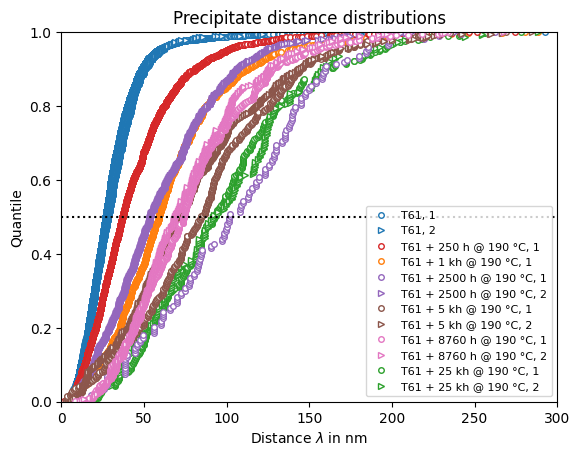

In [20]:
# Delauney triangulation of X and Y coordinates to obtain the average precipitate distance.
# This is our pmdco:AnalyzingProcess that creates new pmd:SecondaryData
lambdas_50pct = dict()
#plt.subplots(figsize=(4, 4))
color_idx = 0
for matl_designation, matl_group in df.groupby(by="matl_designation_value"):
    for specimen, specimen_group in matl_group.groupby(by="specimen"):
        distances = list()
        for img, img_group in specimen_group.groupby(by="img"):
            point_coords = np.vstack((img_group["coord_y_value"], img_group["coord_x_value"])).T
            tri = Delaunay(point_coords)
            for simplex in tri.simplices:
                #Compute the three distances of the points 1-2, 1-3, 2-3
                for i,j in ((0,1), (0, 2), (1,2)):
                    point = (point_coords[simplex[i]], point_coords[simplex[j]])
                    distance = euclidean(point[0], point[1])
                    # Convert from px to nm
                    distance = distance/img_group["calibr_factor_value"].iloc[0] 
                    distances.append(distance)
        X = np.sort(distances)
        Y = np.linspace(0., 1., num=len(X))
        # Determine the distance-value at approx quantil 0.5
        lambda_50pct = X[len(X)//2]
        lambdas_50pct[specimen] = (matl_designation, lambda_50pct)
        # We only plot the particle distance distribution for non-creep testpieces because
        # the graph gets to crowded otherwise
        markers = {"1":"o", "2":">"}
        color   = list(mcolors.TABLEAU_COLORS.values())[color_idx]
        s       = specimen_group.iloc[0]["specimen_name_value"][-1]
        label   = matl_designation + ", " + s
        if "<NA>" == matl_group["creep_stress_value"].iloc[0]:
            plt.plot(X, Y, marker=markers[s], 
                           label=label, 
                           linestyle="none",
                           fillstyle="full",
                           markerfacecolor="white",
                           color=color,
                           markersize=4)
    if "<NA>" == matl_group["creep_stress_value"].iloc[0]:
        color_idx += 1
    
plt.plot([0, 300], [0.5, 0.5], ":", color="k")
plt.xlabel("Distance $\lambda$ in nm")
plt.ylabel("Quantile")
plt.ylim(0., 1.)
plt.xlim(0., 300.)
plt.title("Precipitate distance distributions")
handles, labels = plt.gca().get_legend_handles_labels()
new_order = [0, 1, 5, 2, 6, 7, 8, 9, 10, 11, 3, 4]
ordered_handles = [handles[idx] for idx in new_order] 
ordered_labels  = [labels[idx] for idx in new_order]
plt.legend(ordered_handles, ordered_labels, fontsize="8")
plt.show()


# Write the computed results of the analysing process to a new graph i



In [21]:
PATH = 2
i = Graph()
# Definition of IRI prefixes and assignment of namespaces
pmdco = Namespace("https://w3id.org/pmd/co/")
i.bind("pmdco", pmdco)
pgo = Namespace("https://w3id.org/pmd/pgo/")
i.bind("pgo", pgo)
pmdao_pge = Namespace("https://w3id.org/pmd/resource/pge/")
i.bind("pmdao_pge", pmdao_pge)
pmdao_pge_pd = Namespace("https://w3id.org/pmd/resource/pge/precip_distance/")
i.bind("pmdao_pge_pd", pmdao_pge_pd)
pmdao_pge_s = Namespace("https://w3id.org/pmd/resource/pge/specimen/")
i.bind("pmdao_pge_s", pmdao_pge_s)
pmdao_pge_ap = Namespace("https://w3id.org/pmd/resource/pge/analysing_process/")
i.bind("pmdao_pge_ap", pmdao_pge_ap)

qudt = Namespace("http://qudt.org/vocab/unit/")
i.bind("qudt", qudt)
prov = Namespace("http://www.w3.org/ns/prov#")
i.bind("prov", prov)

# Lets talk about the software agent that performed the computation of the pgo:AveragePrecipitateDistance first.
# We use the notebooks URL as resource identifier
notebook = URIRef("https://github.com/materialdigital/demo-orowan/blob/main/orowan_mechanism_demo.ipynb")
i.add((notebook, a, prov.SoftwareAgent))
i.add((notebook, prov.hadPrimarySource, Literal("https://github.com/materialdigital/demo-orowan/blob/main/orowan_mechanism_demo.ipynb")))

# Then talk about the indivdual analysing processes that have computed the pgo:AveragePrecipitateDistance,
# one distance per specimen
for specimen, (matl_designation, lambda_50pct) in lambdas_50pct.items():
    # We first extract the specimen's ID from the specimen's URI in order to give the 
    # pecipitate distance instance and the analysing process a similar name. 
    specimen_ID         = os.path.basename(urlparse(specimen)[PATH])
    analyzing_process   = URIRef(pmdao_pge_ap +  f"{specimen_ID}")
    avg_precip_distance = URIRef(pmdao_pge_pd +  f"{specimen_ID}")

    i.add((analyzing_process, a, pmdco.AnalysingProcess))
    i.add((analyzing_process, prov.wasAssociatedWith, notebook))
    i.add((analyzing_process, pmdco.output, avg_precip_distance))

    i.add((avg_precip_distance, a, pgo.AveragePrecipitateDistance))
    i.add((avg_precip_distance, a, pmdco.SecondaryData))
    i.add((avg_precip_distance, pmdco.value, Literal(lambda_50pct)))
    i.add((avg_precip_distance, pmdco.unit, qudt.NanoM))
    
    # Link the avg precip distance as a characteristic to the specimen it originated from
    i.add((URIRef(specimen), pmdco.characteristic, avg_precip_distance))

In [22]:
# Serialize the newly generated knowledge into a file ...
i.serialize("TEM-data-addition.rdf", format='application/rdf+xml', encoding="utf-8")

#  ... and import into our triple_store
triple_store.get_ontology("file://TEM-data-addition.rdf").load()


get_ontology("file://TEM-data-addition.rdf#")

# Query TEM and tensile test data to create correlations (Orowan use case)

In [23]:
# Query for all material states, for which there are values of the average precipitate distance and Rp0.2; returning the material state, average precipitate distance, and Rp0.2.

query = """
PREFIX pmdco: <https://w3id.org/pmd/co/>
PREFIX pgo: <https://w3id.org/pmd/pgo/>
PREFIX tto: <https://w3id.org/pmd/tto/>
SELECT DISTINCT \
    ?matl_designation_tem_specimen \
    ?proc_TEM \
    ?avg_distance_value \
    ?avg_distance_unit \
    ?proc_TT \
    ?rp02_value \
    ?rp02_unit
WHERE {

?avg_distance            a                    pgo:AveragePrecipitateDistance .
?avg_distance            pmdco:value          ?avg_distance_value .
?avg_distance            pmdco:unit           ?avg_distance_unit .
?specimen                pmdco:characteristic ?matl_designation_tem .
?specimen                pmdco:characteristic ?avg_distance .
?matl_designation_tem    a                    pmdco:MaterialDesignation .
?matl_designation_tem    pmdco:value          ?matl_designation_tem_specimen .


# Match a specimen that is input to a TEM-process and has 
# a material designation.
?proc_TEM                a                    pmdco:TransmissionElectronMicroscopy .
?proc_TEM                pmdco:input          ?specimen .
?specimen                a                    pmdco:Specimen .
 
# Match a tensile test at 20 °C that has Rp02 as output and 
# has material a material designation. 
?proc_TT                 a                    tto:TensileTest .
?proc_TT                 pmdco:characteristic ?test_tempr .
?test_tempr              a                    pmdco:EnvironmentalTemperature .
?test_tempr              pmdco:value          "20"^^xsd:float .
?proc_TT                 pmdco:characteristic ?matl_designation_tt .
?matl_designation_tt     a                    pmdco:MaterialDesignation .
?matl_designation_tt     pmdco:value          ?matl_designation_tt_specimen .
?proc_TT                 pmdco:output         ?output .
?output                  a                    tto:Rp02 .
?output                  pmdco:value          ?rp02_value .
?output                  pmdco:unit           ?rp02_unit .

# Keep those whose material designation is equal 
FILTER (str(?matl_designation_tem_specimen)=str(?matl_designation_tt_specimen))
}
"""
columns = ["matl_designation_tem_specimen",
           "proc_TEM", 
           "avg_distance_value",
           "avg_distance_unit",
           "proc_TT", 
           "rp02_value", 
           "rp02_unit"]

mapper =dict(zip(range(len(columns)), columns))
res = triple_store.sparql(query)
df = sparql_result_to_df(res).rename(columns=mapper)
display(df)

,matl_designation_tem_specimen,proc_TEM,avg_distance_value,avg_distance_unit,proc_TT,rp02_value,rp02_unit
0,T61,https://w3id.org/pmd/resource/pge/tem_process/...,28.281004,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR5RTzl1_pr...,365.0,http://qudt.org/vocab/unit/MegaPa
1,T61,https://w3id.org/pmd/resource/pge/tem_process/...,26.773351,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR5RTzl1_pr...,365.0,http://qudt.org/vocab/unit/MegaPa
2,T61 + 1 kh @ 190 °C,https://w3id.org/pmd/resource/pge/tem_process/...,59.220954,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR1RTd6_pro...,278.0,http://qudt.org/vocab/unit/MegaPa
3,T61 + 25 kh @ 190 °C,https://w3id.org/pmd/resource/pge/tem_process/...,92.549474,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR9RTzl1_pr...,236.0,http://qudt.org/vocab/unit/MegaPa
4,T61 + 25 kh @ 190 °C,https://w3id.org/pmd/resource/pge/tem_process/...,91.720588,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR9RTzl1_pr...,236.0,http://qudt.org/vocab/unit/MegaPa
5,T61 + 8760 h @ 190 °C,https://w3id.org/pmd/resource/pge/tem_process/...,74.010716,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR2RTd3_pro...,250.0,http://qudt.org/vocab/unit/MegaPa
6,T61 + 8760 h @ 190 °C,https://w3id.org/pmd/resource/pge/tem_process/...,68.896076,http://qudt.org/vocab/unit/NanoM,https://w3id.org/pmd/resource/tte/ABR2RTd3_pro...,250.0,http://qudt.org/vocab/unit/MegaPa


# Plot Orowan relation from tabular data 

+----+-----------------------+-------------------------+--------------+
|    | Material state        |   Precip. distance [nm] |   Rp02 [MPa] |
|----+-----------------------+-------------------------+--------------|
|  0 | T61                   |                 28.281  |          365 |
|  1 | T61                   |                 26.7734 |          365 |
|  2 | T61 + 1 kh @ 190 °C   |                 59.221  |          278 |
|  3 | T61 + 25 kh @ 190 °C  |                 92.5495 |          236 |
|  4 | T61 + 25 kh @ 190 °C  |                 91.7206 |          236 |
|  5 | T61 + 8760 h @ 190 °C |                 74.0107 |          250 |
|  6 | T61 + 8760 h @ 190 °C |                 68.8961 |          250 |
+----+-----------------------+-------------------------+--------------+


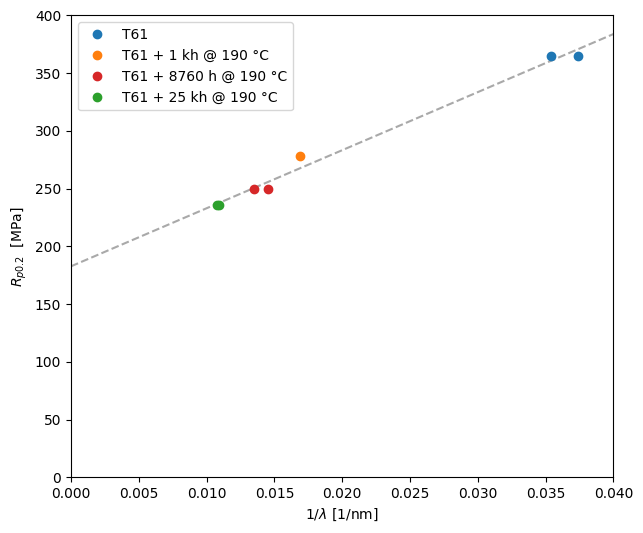

In [24]:
from scipy.stats import linregress
import tabulate
plt.subplots(figsize=(7, 6))

# First plot the regression ...
X = 1./df["avg_distance_value"]
Y = df["rp02_value"]

slope, intercept, r, p, se = linregress(X, Y)
x = np.linspace(0, 0.04)
plt.plot(x, slope*x+intercept, "--", color="darkgrey")

# ... then the individual datapoints on top
for designation, group in df.groupby(by="matl_designation_tem_specimen"):
    X = 1./group["avg_distance_value"]
    Y = group["rp02_value"]
    plt.plot(X, Y, marker="o", label=designation, linestyle="none")


    
handles, labels = plt.gca().get_legend_handles_labels()
new_order = [0, 1, 3, 2]
ordered_handles = [handles[idx] for idx in new_order] 
ordered_labels  = [labels[idx] for idx in new_order]
plt.legend(ordered_handles, ordered_labels)
plt.xlim(0,0.04)
plt.ylim(0,400)
plt.xlabel("$1/\lambda$ [1/nm]")
plt.ylabel("$R_{p0.2}$  [MPa]")
#plt.title("Correlation according to Orowan")

mapper = {"matl_designation_tem_specimen":"Material state", 
          "avg_distance_value":"Precip. distance [nm]",
          "rp02_value":"Rp02 [MPa]"}
tbl = df[["matl_designation_tem_specimen", "avg_distance_value", "rp02_value"]].rename(columns=mapper)
print(tabulate.tabulate(tbl, headers='keys', tablefmt='psql'))
plt.savefig("orowan.png", dpi=600)
plt.show()
